## *Project milestone 3*

In [3]:
import pandas as pd
import numpy as np
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from IPython.display import display
from geopy.distance import geodesic
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## *Quick summary of project milestone 2*
In project milestone 2, we performed an extensive data preprocessing. Specifically, we were given data from the websites: RateBeer and BeerAdvocate. Since we wanted to combine these two datasets and then perform further analysis, we needed a way to merge them into a single datasets my taking care of many intersection and consistency issues, such as the same users appearing in both websites or the same beer being assigned to different beer styles. We cleaned the data, put it in a format that is more suitable for our analysis and filtered it based on the set of locations and year range to be considered. Lastly, we performed some exploratory data analysis to get a better understanding of the data.

The resulting datasets were saved in the "FilteredData" folder. In this milestone, we load these datasets and perform further analysis on beer preferences and their evolution with respect to time and location.




In [4]:
beers = pd.read_csv("dataset/FilteredData/beers.csv")
breweries = pd.read_csv("dataset/FilteredData/breweries.csv")
ratings = pd.read_csv("dataset/FilteredData/ratings.csv", dtype = {'user_id': str})
users = pd.read_csv("dataset/FilteredData/users.csv", dtype = {'user_id': str})

## *Extracting the beer preferences at each location for each year*

We define the beer preference similarity between locations based on two different criteria:

Their preferred beer styles or preferred locations of breweries. For example, if we examine a pair of locations and the ratings coming from these locations indicate that they both prefer "Imperial Stout" as the beer style or they both prefer beers from "Belgium" as the brewery location, then we say that these locations are similar in terms of their beer preference.

For each criterion (beer style or brewery location), we define the "preference" again based on two different criteria: quantitative or qualitative (popularity-wise or rating-wise). As the names indicate, for each location the popularity-based approach captures the beer style or brewery location that got the highest number of ratings, whereas the rating-based approach captures the beer style or brewery location that got the highest average rating. 

Note that for the popularity-based approach, we require a style or brewery location to be at least as popular (in terms of its percentage in total number of ratings) as its total global popularity. For the rating-based approach, we apply a threshold (10 for styles and 20 for brewery locations) for the number of ratings that a style or brewery location should have in order to be considered.

The functions "location_style_stats()" and "location_brewery_country_stats()" used to extract the beer preferences can be found in the helpers.py file.

### *Popularity-based beer style preferences*

In [5]:
all_years_list = sorted(ratings['year'].unique())
style_popularities_by_year = pd.DataFrame()
for year in all_years_list:
    location_style = location_style_stats(ratings.copy(), users.copy(), year, loc_style_threshold = 10, rating_flag = False)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_most_popular = location_style_groupedby_loc['popularity_percentage'].idxmax()
    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style']]
    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    style_popularities_by_year = pd.concat([style_popularities_by_year, most_popular_styles_by_location], axis = 1)

style_popularities_by_year



### *Popularity-based beer style preferences - Top 3*

For beer style preferences, we also provide the dataframes containing the top 3 beer styles (instead of only the top one) for each location. These dataframes will be used for Jaccard beer style preference similary calculations between different locations in later parts of the notebook.

In [6]:
all_years_list = sorted(ratings['year'].unique())
style_popularities_by_year_top3 = pd.DataFrame()
for year in all_years_list:
    location_style = location_style_stats(ratings.copy(), users.copy(), year, loc_style_threshold = 10, rating_flag = False)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_most_popular = location_style_groupedby_loc.apply(lambda x: x.nlargest(3, 'popularity_percentage')).index.values
    idx_most_popular = [x[1] for x in idx_most_popular]
    most_popular_styles_by_location = location_style.loc[idx_most_popular]
    three_most_popular_styles_by_location = most_popular_styles_by_location.groupby('location')['style'].agg(list).to_frame()
    three_most_popular_styles_by_location = three_most_popular_styles_by_location.rename(columns = {'style': str(year)})
    style_popularities_by_year_top3 = pd.concat([style_popularities_by_year_top3, three_most_popular_styles_by_location], axis = 1)
    
style_popularities_by_year_top3

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,"[Pale Lager, Pilsener, Golden Ale/Blond Ale]","[Pale Lager, Pilsener, Golden Ale/Blond Ale]","[Pale Lager, Pilsener, Golden Ale/Blond Ale]","[Pale Lager, Golden Ale/Blond Ale, Pilsener]","[Pale Lager, Golden Ale/Blond Ale, American Pa...","[Pale Lager, American Pale Ale, Golden Ale/Blo...","[Pale Lager, American Pale Ale, Golden Ale/Blo...","[India Pale Ale (IPA), American Pale Ale, Pale...","[India Pale Ale (IPA), American Pale Ale, Pale...","[American Pale Ale, Pale Lager, Golden Ale/Blo...","[American Pale Ale, Pale Lager, Golden Ale/Blo...","[India Pale Ale (IPA), American Pale Ale, Pale..."
Belgium,"[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Strong Ale, Belgian Ale, Pale Lager]","[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Strong Ale, Belgian Ale, Abbey Tripel]","[Belgian Ale, Belgian Strong Ale, Abbey Tripel]","[Belgian Ale, Belgian Strong Ale, Saison]","[Belgian Ale, Belgian Strong Ale, Abbey Tripel]","[Imperial Stout, Belgian Ale, Belgian Strong Ale]"
Brazil,"[Pale Lager, Pilsener, German Hefeweizen]","[Pale Lager, Belgian Strong Ale, Belgian Ale]","[Pale Lager, Pilsener, Belgian Strong Ale]","[Pale Lager, Pilsener, German Hefeweizen]","[Pale Lager, Belgian Strong Ale, Pilsener]","[Pale Lager, Belgian Strong Ale, Pilsener]","[Pale Lager, Belgian Strong Ale, Pilsener]","[Pale Lager, Belgian Strong Ale, German Hefewe...","[Pale Lager, Belgian Strong Ale, German Hefewe...","[Pale Lager, Belgian Strong Ale, German Hefewe...","[Pale Lager, Belgian Strong Ale, German Hefewe...","[Pale Lager, Belgian Strong Ale, Golden Ale/Bl..."
Canada,"[Pale Lager, Golden Ale/Blond Ale, Fruit Beer]","[Pale Lager, Golden Ale/Blond Ale, Pilsener]","[Pale Lager, India Pale Ale (IPA), Belgian Str...","[Pale Lager, Belgian Strong Ale, Golden Ale/Bl...","[Pale Lager, Belgian Strong Ale, Golden Ale/Bl...","[Pale Lager, Golden Ale/Blond Ale, Spice/Herb/...","[India Pale Ale (IPA), Pale Lager, Belgian Str...","[Pale Lager, American Pale Ale, Saison]","[American Pale Ale, Saison, Pale Lager]","[Saison, American Pale Ale, Sour/Wild Ale]","[Saison, Sour/Wild Ale, American Pale Ale]","[Sour/Wild Ale, Saison, Stout]"
Croatia,"[Pale Lager, Pilsener, Fruit Beer]","[Pale Lager, Pilsener, Fruit Beer]","[Pale Lager, Pilsener, Fruit Beer]","[Pale Lager, Pilsener, Dunkel/Tmavý]","[Pilsener, Pale Lager, Dunkel/Tmavý]","[Pale Lager, Pilsener, Fruit Beer]","[Pale Lager, Fruit Beer, Pilsener]","[Pale Lager, Pilsener, Fruit Beer]","[Pale Lager, Pilsener, German Hefeweizen]","[Pale Lager, Pilsener, American Pale Ale]","[Pale Lager, American Pale Ale, Pilsener]","[Pale Lager, American Pale Ale, Pilsener]"
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Porter, American Pale Ale]","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Imperial IPA, Imperial ...","[India Pale Ale (IPA), Imperial IPA, Imperial ...","[India Pale Ale (IPA), Imperial IPA, Imperial ...","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Imperial IPA, Imperial ...","[India Pale Ale (IPA), Imperial IPA, Imperial ..."
"United States, Washington","[India Pale Ale (IPA), Imperial Stout, America...","[India Pale Ale (IPA), Porter, Imperial IPA]","[India Pale Ale (IPA), Imperial Stout, Belgian...","[India Pale Ale (IPA), Imperial IPA, Imperial ...","[India Pale Ale (IPA), Imperial IPA, American ...","[India Pale Ale (IPA), Imperial Stout, Imperia...","[India Pale Ale (IPA), Impe

### *Rating-based style preferences*

In [7]:
all_years_list = sorted(ratings['year'].unique())
style_ratings_by_year = pd.DataFrame()
for year in all_years_list:
    location_style = location_style_stats(ratings.copy(), users.copy(), year, loc_style_threshold = 10, rating_flag = True)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_highest_rated = location_style_groupedby_loc['z_score'].idxmax()
    highest_rated_styles_by_location = location_style.loc[idx_highest_rated]
    highest_rated_styles_by_location = highest_rated_styles_by_location[['location', 'style']]
    highest_rated_styles_by_location.set_index('location', inplace = True)
    highest_rated_styles_by_location = highest_rated_styles_by_location.rename(columns = {'style': str(year)})
    style_ratings_by_year = pd.concat([style_ratings_by_year, highest_rated_styles_by_location], axis = 1)

style_ratings_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Eisbock,Abt/Quadrupel,Lambic Style - Gueuze,Imperial Stout,Abt/Quadrupel
Belgium,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Abt/Quadrupel,Imperial Stout,American Strong Ale,Imperial Stout,Imperial Stout,Imperial Stout
Brazil,German Hefeweizen,Abt/Quadrupel,Abt/Quadrupel,Belgian Strong Ale,Imperial Stout,Lambic Style - Fruit,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abbey Tripel
Canada,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze
Croatia,Belgian Strong Ale,Porter,Abt/Quadrupel,Imperial Stout,Imperial Stout,Imperial Stout,Imperial Stout,Imperial Stout,Imperial Stout,Imperial Stout,Abt/Quadrupel,Lambic Style - Fruit
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",Abt/Quadrupel,Abt/Quadrupel,Sour Red/Brown,Lambic Style - Gueuze,Sour/Wild Ale,Lambic Style - Gueuze,Lambic Style - Unblended,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze
"United States, Washington",Abt/Quadrupel,Abt/Quadrupel,Lambic Style - Gueuze,Sour Red/Brown,Lambic Style - Unblended,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze,Lambic Style - Gueuze
"United States, West Virginia",Doppelbock,Imperial Stout,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Abt/Quadrupel,Imperial Stout,Lambic Style - Fruit,Imperial Stout,Abt/Quadrupel


### *Rating-based beer style preferences - Top 3*

In [8]:
all_years_list = sorted(ratings['year'].unique())
style_ratings_by_year_top3 = pd.DataFrame()
for year in all_years_list:
    location_style = location_style_stats(ratings.copy(), users.copy(), year, loc_style_threshold = 10, rating_flag = True)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_highest_rated = location_style_groupedby_loc.apply(lambda x: x.nlargest(3, 'z_score')).index.values
    idx_highest_rated = [x[1] for x in idx_highest_rated]
    highest_rated_styles_by_location = location_style.loc[idx_highest_rated]
    three_highest_rated_styles_by_location = highest_rated_styles_by_location.groupby('location')['style'].agg(list).to_frame()
    three_highest_rated_styles_by_location = three_highest_rated_styles_by_location.rename(columns = {'style': str(year)})
    style_ratings_by_year_top3 = pd.concat([style_ratings_by_year_top3, three_highest_rated_styles_by_location], axis = 1)
    
style_ratings_by_year_top3

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,"[Abt/Quadrupel, Imperial IPA, Lambic Style - G...","[Abt/Quadrupel, Imperial Stout, Imperial IPA]","[Abt/Quadrupel, Imperial IPA, Imperial Stout]","[Abt/Quadrupel, Eisbock, Imperial Stout]","[Abt/Quadrupel, Imperial Stout, Eisbock]","[Abt/Quadrupel, Imperial Stout, American Stron...","[Abt/Quadrupel, American Strong Ale , Lambic S...","[Eisbock, Abt/Quadrupel, Lambic Style - Gueuze]","[Abt/Quadrupel, Imperial Stout, Lambic Style -...","[Lambic Style - Gueuze, Weizen Bock, Abt/Quadr...","[Imperial Stout, Lambic Style - Gueuze, Abt/Qu...","[Abt/Quadrupel, Lambic Style - Gueuze, Old Ale]"
Belgium,"[Abt/Quadrupel, Lambic Style - Gueuze, Sour/Wi...","[Abt/Quadrupel, Imperial Stout, Imperial IPA]","[Abt/Quadrupel, Imperial Stout, Barley Wine]","[Abt/Quadrupel, Imperial Stout, Barley Wine]","[Abt/Quadrupel, Imperial Stout, Lambic Style -...","[Lambic Style - Gueuze, Abt/Quadrupel, Imperia...","[Abt/Quadrupel, Imperial Stout, American Stron...","[Imperial Stout, Eisbock, Lambic Style - Unble...","[American Strong Ale , Imperial Stout, Imperia...","[Imperial Stout, Lambic Style - Gueuze, Americ...","[Imperial Stout, Mead, Imperial IPA]","[Imperial Stout, Baltic Porter, American Stron..."
Brazil,"[German Hefeweizen, Pilsener, Pale Lager]","[Abt/Quadrupel, Barley Wine, Belgian Strong Ale]","[Abt/Quadrupel, Imperial Stout, Belgian Strong...","[Belgian Strong Ale, Abbey Tripel, India Pale ...","[Imperial Stout, Belgian Strong Ale, Lambic St...","[Lambic Style - Fruit, Porter, Barley Wine]","[Abt/Quadrupel, Old Ale, Abbey Tripel]","[Abt/Quadrupel, Sour/Wild Ale, Belgian Strong ...","[Abt/Quadrupel, Imperial Stout, Lambic Style -...","[Abt/Quadrupel, Imperial Stout, American Stron...","[Abt/Quadrupel, Imperial Stout, Sour Red/Brown]","[Abbey Tripel, Belgian Strong Ale, Abt/Quadrupel]"
Canada,"[Abt/Quadrupel, Lambic Style - Unblended, Impe...","[Abt/Quadrupel, Lambic Style - Unblended, Impe...","[Abt/Quadrupel, Imperial Stout, Sour/Wild Ale]","[Abt/Quadrupel, Lambic Style - Gueuze, Imperia...","[Abt/Quadrupel, Grodziskie/Gose/Lichtenhainer,...","[Abt/Quadrupel, Lambic Style - Unblended, Lamb...","[Lambic Style - Gueuze, Abt/Quadrupel, Lambic ...","[Abt/Quadrupel, Lambic Style - Gueuze, Imperia...","[Abt/Quadrupel, Imperial Stout, Lambic Style -...","[Lambic Style - Gueuze, Imperial Stout, Abt/Qu...","[Lambic Style - Gueuze, Imperial Stout, Lambic...","[Lambic Style - Gueuze, Lambic Style - Unblend..."
Croatia,"[Belgian Strong Ale, Abbey Tripel, Abbey Dubbel]","[Porter, Belgian Strong Ale, Abbey Dubbel]","[Abt/Quadrupel, Imperial Stout, Baltic Porter]","[Imperial Stout, India Pale Ale (IPA), Belgian...","[Imperial Stout, India Pale Ale (IPA), Weizen ...","[Imperial Stout, Imperial IPA, Barley Wine]","[Imperial Stout, Barley Wine, Imperial IPA]","[Imperial Stout, Abbey Dubbel, Abbey Tripel]","[Imperial Stout, Weizen Bock, Abt/Quadrupel]","[Imperial Stout, Black IPA, Abt/Quadrupel]","[Abt/Quadrupel, Imperial Stout, American Stron...","[Lambic Style - Fruit, Imperial Stout, Lambic ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia","[Abt/Quadrupel, Sour/Wild Ale, Eisbock]","[Abt/Quadrupel, Sour/Wild Ale, Imperial Stout]","[Sour Red/Brown, Abt/Quadrupel, Lambic Style -...","[Lambic Style - Gueuze, Sour Red/Brown, Imperi...","[Sour/Wild Ale, Weizen Bock, Lambic Style - Un...","[Lambic Style - Gueuze, Eisbock, Abt/Quadrupel]","[Lambic Style - Unblended, Lambic Style - Gueu...","[Lambic Style - Gueuze, Imperial Stout, Eisbock]","[Lambic Style - Gueuze, Lambic Style - Fruit, ...","[Lambic Style - Gueuze, Imperial Stout, Lambic...","[Lambic Style - Gueuze, Lambic Style - Fruit, ...","[Lambic Style - Gueuze, Lambic Style - Unblend..."
"United States, Washington","[Abt/Quadrupel, Imperial Stout, Eisbock]","[Abt/Quadrupel, Imperial Stout, Eisbock]","[Lambic Style - Gueuze, Sour Red/Brown, Sour/W...","[Sour Red/Brown, Lambic Style - U

### *Popularity-based brewery location preferences*

In [9]:
all_years_list = sorted(ratings['year'].unique())
bc_popularities_by_year = pd.DataFrame()
for year in all_years_list:
    location_bc = location_brewery_country_stats(ratings.copy(), users.copy(), breweries.copy(), year, loc_brewery_threshold = 20, rating_flag = False)
    location_bc_gb_loc = location_bc.groupby('location')
    idx_most_popular = location_bc_gb_loc['popularity_percentage'].idxmax()
    most_popular_bc_by_location = location_bc.loc[idx_most_popular]
    most_popular_bc_by_location = most_popular_bc_by_location[['location', 'brewery_location']]
    most_popular_bc_by_location.set_index('location', inplace = True)
    most_popular_bc_by_location = most_popular_bc_by_location.rename(columns = {'brewery_location': str(year)})
    bc_popularities_by_year = pd.concat([bc_popularities_by_year, most_popular_bc_by_location], axis = 1)
    
bc_popularities_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia,Australia
Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium,Belgium
Brazil,Brazil,Belgium,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil,Brazil
Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada
Croatia,Belgium,Belgium,Germany,Czech Republic,Germany,Germany,Germany,Germany,Germany,Germany,Croatia,Croatia
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, Virginia","United States, Virginia","United States, Virginia","United States, Virginia"
"United States, Washington","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, Washington","United States, Washington","United States, Washington"
"United States, West Virginia","United States, Pennsylvania","United States, Pennsylvania","United States, California","United States, New York","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, California","United States, Ohio"


### *Rating-based brewery location preferences*

In [10]:
all_years_list = sorted(ratings['year'].unique())
bc_ratings_by_year = pd.DataFrame()
for year in all_years_list:
    location_bc = location_brewery_country_stats(ratings.copy(), users.copy(), breweries.copy(), year, loc_brewery_threshold = 20, rating_flag = True)
    location_bc_gb_loc = location_bc.groupby('location')
    idx_highest_rated = location_bc_gb_loc['z_score'].idxmax()
    highest_rated_bc_by_location = location_bc.loc[idx_highest_rated]
    highest_rated_bc_by_location = highest_rated_bc_by_location[['location', 'brewery_location']]
    highest_rated_bc_by_location.set_index('location', inplace=True)
    highest_rated_bc_by_location = highest_rated_bc_by_location.rename(columns={'brewery_location': str(year)})
    bc_ratings_by_year = pd.concat([bc_ratings_by_year, highest_rated_bc_by_location], axis=1)
    
bc_ratings_by_year

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,"United States, California","United States, Colorado","United States, Oregon",Norway,Norway,"United States, Michigan","United States, Alaska",Norway,"United States, Vermont",Norway,"United States, Oklahoma","United States, Massachusetts"
Belgium,"United States, California","United States, California","United States, Michigan","United States, Georgia","United States, Oregon",Norway,"United States, Illinois","United States, Vermont","United States, Iowa","United States, Vermont","United States, South Carolina","United States, Ohio"
Brazil,Germany,Canada,"United States, California",Belgium,Belgium,"United States, California",Belgium,"United States, Indiana","United States, Florida","United States, Illinois","United States, Florida","United States, Massachusetts"
Canada,"United States, Alaska",Norway,Norway,Norway,Norway,Norway,"United States, Indiana","United States, Iowa","United States, Vermont","United States, Oklahoma","United States, Iowa","United States, Oklahoma"
Croatia,Belgium,Belgium,Belgium,England,Scotland,Sweden,Belgium,Scotland,Norway,Norway,Norway,"United States, Oregon"
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia","United States, Connecticut","United States, Connecticut",Norway,Norway,"United States, Minnesota","United States, Alaska","United States, Alaska","United States, Iowa","United States, Iowa",Norway,Switzerland,"United States, Oklahoma"
"United States, Washington","United States, Connecticut",Norway,Norway,Norway,"United States, Indiana",Switzerland,Belgium,"United States, Iowa","United States, Iowa","United States, Vermont","United States, Iowa","United States, Wyoming"
"United States, West Virginia","United States, Ohio",Belgium,"United States, Michigan",Belgium,Belgium,Belgium,"United States, Michigan",Belgium,Belgium,"United States, Indiana",Belgium,"United States, Oregon"


## *Extracting global beer preferences for each year*

Now we try to find the global beer preferences for each year. Simply looking at the total number of ratings and their distribution in that year would not represent the preference of the whole world since the locations with high populations heavily dominate the aggregated results. Therefore, we needed a way to aggregate the beer preferences coming from the individual locations at that year. We did not want to do this simply by finding the beer style or brewery location that was declared as the preferred one in the highest number of locations. This kind of approach would result in each location giving all their 'vote' only to their 'most' preferred beer style or brewery location, their 'second' or 'third' preferred ones would not receive any 'vote' no matter how close they are to the 'most' preferred one. This would throw away a significant amount of preference information available for each location.

Instead, we came up with a much more thoughtful and interesting approach. If the Eurovision Song Contest can do it, so can we! In the Eurovision Song Contest, each country gives points to their top 10 favorite songs. The song that gets the highest number of points in total is the winner of the year. We decided to do something similar. For each location, we assign points to their top 10 favorite beer styles or brewery locations. The beer style or brewery location that gets the highest number of points wins the contest. The points are assigned as follows: 12 points for the most preferred beer style or brewery location, 10 points for the second most preferred one, 8 points for the third most preferred one, and so on, the exact rating system used in the contest. This way, we obtain a better representation of the beer preferences of the whole globe.

Below, we apply the above-given approach to extract the global beer preferences for each year. Note that we normally treat each U.S. state as a separate location. However, for the global beer preference extraction, we treat the whole U.S. as a single location or otherwise U.S. would have too many votes in the contest. Therefore, our 'location_style_stats()' and 'location_brewery_country_stats()' functions have a boolean argument called 'global_flag' and if it is set to True, it replaces all the U.S. state names and replace them all with the name 'United States' before it begins with the point calculations. Furthermore, we provide not only the top 1 but top 10 preferences for each year with their collected points since this information will be used in our bar chart race visualizations in the website!

### *Popularity-based global beer style preferences*

In [11]:
all_years_list = sorted(ratings['year'].unique())
global_style_popularity_points_by_year = pd.DataFrame()
points = [12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
for year in all_years_list:
    style_popularity_points_dict = {key: 0 for key in ratings['style'].unique().tolist()}
    location_style = location_style_stats(ratings.copy(), users.copy(), year, loc_style_threshold = 10, rating_flag = False, global_flag = True)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_10_most_popular = location_style_groupedby_loc['popularity_percentage'].nlargest(10).index.get_level_values(1)
    most_popular_styles_by_location = location_style.loc[idx_10_most_popular]
    
    point_idx = 0
    prev_location = most_popular_styles_by_location.iloc[0]['location']
    for index, row in most_popular_styles_by_location.iterrows():
        location = row['location']
        if location != prev_location:
            point_idx = 0
            prev_location = location
        style_popularity_points_dict[row['style']] += points[point_idx]
        point_idx += 1
    global_style_popularity_points_by_year[str(year)] = style_popularity_points_dict

global_style_popularities_by_year = global_style_popularity_points_by_year.apply(lambda x: x.nlargest(10).index.tolist()).T
global_style_popularities_by_year_points = global_style_popularity_points_by_year.apply(lambda x: x.nlargest(10).tolist()).T
tuple_list = {column: list(zip(global_style_popularities_by_year[column], global_style_popularities_by_year_points[column])) for column in global_style_popularities_by_year.columns}
global_style_popularities_by_year = pd.DataFrame(tuple_list, index = global_style_popularities_by_year.index)

global_style_popularities_by_year.columns = ['1st Most Popular', '2nd Most Popular', '3rd Most Popular', '4th Most Popular', '5th Most Popular', '6th Most Popular', '7th Most Popular', '8th Most Popular', '9th Most Popular', '10th Most Popular']
global_style_popularities_by_year.index.name = 'Year'
global_style_popularities_by_year

,1st Most Popular,2nd Most Popular,3rd Most Popular,4th Most Popular,5th Most Popular,6th Most Popular,7th Most Popular,8th Most Popular,9th Most Popular,10th Most Popular
Year,,,,,,,,,,
2006,"(Pilsener, 117)","(Pale Lager, 106)","(Belgian Strong Ale, 82)","(German Hefeweizen, 69)","(Golden Ale/Blond Ale, 66)","(Belgian Ale, 63)","(Premium Bitter/ESB, 62)","(Porter, 58)","(Bitter, 56)","(Dunkel/Tmavý, 52)"
2007,"(Pale Lager, 118)","(Pilsener, 102)","(Belgian Strong Ale, 78)","(Golden Ale/Blond Ale, 74)","(Bitter, 66)","(Porter, 66)","(German Hefeweizen, 66)","(India Pale Ale (IPA), 65)","(Belgian Ale, 64)","(Fruit Beer, 48)"
2008,"(Pale Lager, 108)","(Pilsener, 100)","(Belgian Strong Ale, 86)","(Imperial Stout, 75)","(Golden Ale/Blond Ale, 71)","(India Pale Ale (IPA), 68)","(Bitter, 66)","(Porter, 63)","(Belgian Ale, 60)","(Fruit Beer, 55)"
2009,"(Pilsener, 108)","(India Pale Ale (IPA), 82)","(Pale Lager, 80)","(Belgian Strong Ale, 64)","(Porter, 62)","(Belgian Ale, 62)","(Imperial Stout, 61)","(Golden Ale/Blond Ale, 53)","(Premium Bitter/ESB, 49)","(American Pale Ale, 48)"
2010,"(Pale Lager, 136)","(Belgian Strong Ale, 81)","(Pilsener, 78)","(India Pale Ale (IPA), 76)","(Imperial Stout, 76)","(Porter, 66)","(Golden Ale/Blond Ale, 64)","(German Hefeweizen, 56)","(Bitter, 51)","(Imperial IPA, 50)"
2011,"(Pale Lager, 134)","(India Pale Ale (IPA), 100)","(Pilsener, 93)","(Imperial Stout, 85)","(Belgian Strong Ale, 84)","(Porter, 66)","(Golden Ale/Blond Ale, 65)","(German Hefeweizen, 64)","(Bitter, 60)","(Belgian Ale, 59)"
2012,"(India Pale Ale (IPA), 112)","(Pale Lager, 104)","(Imperial Stout, 93)","(American Pale Ale, 88)","(Belgian Strong Ale, 84)","(Pilsener, 78)","(Belgian Ale, 78)","(Porter, 77)","(Imperial IPA, 58)","(Golden Ale/Blond Ale, 51)"
2013,"(India Pale Ale (IPA), 116)","(American Pale Ale, 109)","(Pale Lager, 95)","(Imperial Stout, 93)","(Pilsener, 83)","(Belgian Strong Ale, 77)","(Porter, 67)","(Golden Ale/Blond Ale, 59)","(Belgian Ale, 58)","(Imperial IPA, 50)"
2014,"(India Pale Ale (IPA), 154)","(American Pale Ale, 110)","(Pale Lager, 99)","(Imperial Stout, 79)","(Belgian Strong Ale, 74)","(Porter, 69)","(Golden Ale/Blond Ale, 64)","(Saison, 63)","(Belgian Ale, 63)","(Pilsener, 59)"


### *Rating-based global beer style preferences*

In [12]:
all_years_list = sorted(ratings['year'].unique())
global_style_rating_points_by_year = pd.DataFrame()
points = [12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
for year in all_years_list:
    style_rating_points_dict = {key: 0 for key in ratings['style'].unique().tolist()}
    location_style = location_style_stats(ratings.copy(), users.copy(), year, loc_style_threshold = 10, rating_flag = True, global_flag = True)
    location_style_groupedby_loc = location_style.groupby('location')
    idx_10_highest_rated = location_style_groupedby_loc['z_score'].nlargest(10).index.get_level_values(1)
    highest_rated_styles_by_location = location_style.loc[idx_10_highest_rated]
    
    point_idx = 0
    prev_location = highest_rated_styles_by_location.iloc[0]['location']
    for index, row in highest_rated_styles_by_location.iterrows():
        location = row['location']
        if location != prev_location:
            point_idx = 0
            prev_location = location
        style_rating_points_dict[row['style']] += points[point_idx]
        point_idx += 1
    global_style_rating_points_by_year[str(year)] = style_rating_points_dict

global_style_highest_rated_by_year = global_style_rating_points_by_year.apply(lambda x: x.nlargest(10).index.tolist()).T
global_style_highest_rated_by_year_points = global_style_rating_points_by_year.apply(lambda x: x.nlargest(10).tolist()).T

tuple_list = {column: list(zip(global_style_highest_rated_by_year[column], global_style_highest_rated_by_year_points[column])) for column in global_style_highest_rated_by_year.columns}
global_style_highest_rated_by_year = pd.DataFrame(tuple_list, index = global_style_highest_rated_by_year.index)

global_style_highest_rated_by_year.columns = ['1st Highest Rated', '2nd Highest Rated', '3rd Highest Rated', '4th Highest Rated', '5th Highest Rated', '6th Highest Rated', '7th Highest Rated', '8th Highest Rated', '9th Highest Rated', '10th Highest Rated']
global_style_highest_rated_by_year.index.name = 'Year'
global_style_highest_rated_by_year

,1st Highest Rated,2nd Highest Rated,3rd Highest Rated,4th Highest Rated,5th Highest Rated,6th Highest Rated,7th Highest Rated,8th Highest Rated,9th Highest Rated,10th Highest Rated
Year,,,,,,,,,,
2006,"(Imperial Stout, 112)","(Abt/Quadrupel, 111)","(Belgian Strong Ale, 108)","(Imperial IPA, 82)","(Lambic Style - Gueuze, 57)","(Baltic Porter, 47)","(Abbey Tripel, 39)","(Sour/Wild Ale, 38)","(Belgian Ale, 37)","(American Strong Ale , 37)"
2007,"(Abt/Quadrupel, 158)","(Imperial Stout, 154)","(Belgian Strong Ale, 110)","(Imperial IPA, 85)","(Barley Wine, 57)","(Sour Red/Brown, 52)","(Porter, 51)","(American Strong Ale , 50)","(Sour/Wild Ale, 40)","(Lambic Style - Gueuze, 40)"
2008,"(Imperial Stout, 204)","(Abt/Quadrupel, 148)","(Imperial IPA, 119)","(Belgian Strong Ale, 99)","(Sour/Wild Ale, 79)","(Barley Wine, 72)","(Lambic Style - Gueuze, 55)","(Abbey Tripel, 52)","(India Pale Ale (IPA), 45)","(Baltic Porter, 45)"
2009,"(Imperial Stout, 188)","(Abt/Quadrupel, 141)","(Imperial IPA, 100)","(Sour Red/Brown, 79)","(Barley Wine, 72)","(Belgian Strong Ale, 65)","(Sour/Wild Ale, 58)","(Lambic Style - Gueuze, 58)","(American Strong Ale , 51)","(India Pale Ale (IPA), 45)"
2010,"(Imperial Stout, 204)","(Abt/Quadrupel, 156)","(Imperial IPA, 81)","(Lambic Style - Unblended, 81)","(Belgian Strong Ale, 63)","(American Strong Ale , 63)","(Sour Red/Brown, 52)","(Lambic Style - Gueuze, 49)","(Abbey Tripel, 47)","(Black IPA, 45)"
2011,"(Imperial Stout, 196)","(Abt/Quadrupel, 152)","(Imperial IPA, 132)","(Lambic Style - Gueuze, 93)","(Lambic Style - Unblended, 67)","(American Strong Ale , 58)","(Barley Wine, 56)","(Belgian Strong Ale, 48)","(Sour/Wild Ale, 47)","(Black IPA, 43)"
2012,"(Imperial Stout, 193)","(Abt/Quadrupel, 179)","(Imperial IPA, 137)","(Lambic Style - Gueuze, 118)","(Black IPA, 72)","(American Strong Ale , 72)","(Sour/Wild Ale, 60)","(Barley Wine, 53)","(Sour Red/Brown, 48)","(Lambic Style - Unblended, 46)"
2013,"(Imperial Stout, 213)","(Abt/Quadrupel, 209)","(Imperial IPA, 106)","(Lambic Style - Gueuze, 103)","(American Strong Ale , 73)","(Eisbock, 67)","(Black IPA, 58)","(Sour/Wild Ale, 53)","(Barley Wine, 48)","(Lambic Style - Unblended, 48)"
2014,"(Imperial Stout, 244)","(Abt/Quadrupel, 185)","(Lambic Style - Gueuze, 117)","(Imperial IPA, 113)","(American Strong Ale , 88)","(Barley Wine, 70)","(Black IPA, 60)","(Lambic Style - Unblended, 60)","(Eisbock, 58)","(Sour/Wild Ale, 57)"


### *Popularity-based global brewery location preferences*

In [13]:
all_years_list = sorted(ratings['year'].unique())
global_brewery_popularity_points_by_year = pd.DataFrame()
points = [12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
for year in all_years_list:
    brewery_popularity_points_dict = {key: 0 for key in breweries['location'].unique().tolist()}
    location_bc = location_brewery_country_stats(ratings.copy(), users.copy(), breweries.copy(), year, loc_brewery_threshold = 20, rating_flag = False, global_flag = True)
    location_bc_groupedby_loc = location_bc.groupby('location')
    idx_10_most_popular = location_bc_groupedby_loc['popularity_percentage'].nlargest(10).index.get_level_values(1)
    most_popular_breweries_by_location = location_bc.loc[idx_10_most_popular]
    
    point_idx = 0
    prev_location = most_popular_breweries_by_location.iloc[0]['location']
    for index, row in most_popular_breweries_by_location.iterrows():
        location = row['location']
        if location != prev_location:
            point_idx = 0
            prev_location = location
        brewery_popularity_points_dict[row['brewery_location']] += points[point_idx]
        point_idx += 1
    global_brewery_popularity_points_by_year[str(year)] = brewery_popularity_points_dict

global_brewery_popularities_by_year = global_brewery_popularity_points_by_year.apply(lambda x: x.nlargest(10).index.tolist()).T
global_brewery_popularities_by_year_points = global_brewery_popularity_points_by_year.apply(lambda x: x.nlargest(10).tolist()).T

tuple_list = {column: list(zip(global_brewery_popularities_by_year[column], global_brewery_popularities_by_year_points[column])) for column in global_brewery_popularities_by_year.columns}
global_brewery_popularities_by_year = pd.DataFrame(tuple_list, index = global_brewery_popularities_by_year.index)

global_brewery_popularities_by_year.columns = ['1st Most Popular', '2nd Most Popular', '3rd Most Popular', '4th Most Popular', '5th Most Popular', '6th Most Popular', '7th Most Popular', '8th Most Popular', '9th Most Popular', '10th Most Popular']
global_brewery_popularities_by_year.index.name = 'Year'
global_brewery_popularities_by_year

,1st Most Popular,2nd Most Popular,3rd Most Popular,4th Most Popular,5th Most Popular,6th Most Popular,7th Most Popular,8th Most Popular,9th Most Popular,10th Most Popular
Year,,,,,,,,,,
2006,"(Belgium, 104)","(England, 90)","(Germany, 82)","(Netherlands, 53)","(Scotland, 51)","(Czech Republic, 50)","(United States, California, 45)","(France, 40)","(Denmark, 36)","(Sweden, 35)"
2007,"(Germany, 90)","(Belgium, 80)","(England, 78)","(Denmark, 57)","(United States, California, 57)","(Sweden, 49)","(Czech Republic, 45)","(Netherlands, 45)","(Scotland, 44)","(United States, New York, 43)"
2008,"(England, 98)","(Germany, 86)","(Belgium, 80)","(Denmark, 70)","(United States, California, 57)","(Netherlands, 50)","(United States, New York, 44)","(Czech Republic, 43)","(United States, Colorado, 43)","(Scotland, 39)"
2009,"(Germany, 80)","(United States, California, 68)","(United States, New York, 60)","(Belgium, 58)","(England, 56)","(Czech Republic, 51)","(Denmark, 45)","(Sweden, 42)","(United States, Maryland, 38)","(Scotland, 37)"
2010,"(Belgium, 76)","(United States, California, 74)","(Germany, 68)","(England, 68)","(United States, New York, 54)","(Czech Republic, 45)","(Norway, 44)","(Denmark, 42)","(United States, Colorado, 39)","(Canada, 36)"
2011,"(Belgium, 100)","(United States, California, 74)","(Germany, 73)","(England, 60)","(Czech Republic, 51)","(United States, New York, 50)","(Denmark, 46)","(Scotland, 45)","(United States, Maryland, 41)","(Netherlands, 40)"
2012,"(Belgium, 86)","(Germany, 84)","(United States, California, 69)","(England, 58)","(Denmark, 57)","(United States, New York, 57)","(Netherlands, 46)","(Scotland, 43)","(Japan, 34)","(Czech Republic, 34)"
2013,"(Belgium, 86)","(Germany, 78)","(United States, California, 62)","(Denmark, 57)","(England, 48)","(United States, New York, 46)","(Norway, 45)","(United States, Oregon, 45)","(Scotland, 41)","(Czech Republic, 40)"
2014,"(Belgium, 76)","(Germany, 62)","(United States, California, 61)","(Denmark, 55)","(Czech Republic, 54)","(England, 54)","(United States, New York, 44)","(Scotland, 42)","(Japan, 40)","(United States, Oregon, 39)"


### *Rating-based global brewery location preferences*

In [14]:
all_years_list = sorted(ratings['year'].unique())
global_brewery_rating_points_by_year = pd.DataFrame()
points = [12, 10, 8, 7, 6, 5, 4, 3, 2, 1]
for year in all_years_list:
    brewery_rating_points_dict = {key: 0 for key in breweries['location'].unique().tolist()}
    location_bc = location_brewery_country_stats(ratings.copy(), users.copy(), breweries.copy(), year, loc_brewery_threshold = 20, rating_flag = True, global_flag = True)
    location_bc_groupedby_loc = location_bc.groupby('location')
    idx_10_highest_rated = location_bc_groupedby_loc['z_score'].nlargest(10).index.get_level_values(1)
    highest_rated_breweries_by_location = location_bc.loc[idx_10_highest_rated]
    
    point_idx = 0
    prev_location = highest_rated_breweries_by_location.iloc[0]['location']
    for index, row in highest_rated_breweries_by_location.iterrows():
        location = row['location']
        if location != prev_location:
            point_idx = 0
            prev_location = location
        brewery_rating_points_dict[row['brewery_location']] += points[point_idx]
        point_idx += 1
    global_brewery_rating_points_by_year[str(year)] = brewery_rating_points_dict

global_brewery_highest_rated_by_year = global_brewery_rating_points_by_year.apply(lambda x: x.nlargest(10).index.tolist()).T
global_brewery_highest_rated_by_year_points = global_brewery_rating_points_by_year.apply(lambda x: x.nlargest(10).tolist()).T

tuple_list = {column: list(zip(global_brewery_highest_rated_by_year[column], global_brewery_highest_rated_by_year_points[column])) for column in global_brewery_highest_rated_by_year.columns}
global_brewery_highest_rated_by_year = pd.DataFrame(tuple_list, index = global_brewery_highest_rated_by_year.index)

global_brewery_highest_rated_by_year.columns = ['1st Highest Rated', '2nd Highest Rated', '3rd Highest Rated', '4th Highest Rated', '5th Highest Rated', '6th Highest Rated', '7th Highest Rated', '8th Highest Rated', '9th Highest Rated', '10th Highest Rated']
global_brewery_highest_rated_by_year.index.name = 'Year'
global_brewery_highest_rated_by_year

,1st Highest Rated,2nd Highest Rated,3rd Highest Rated,4th Highest Rated,5th Highest Rated,6th Highest Rated,7th Highest Rated,8th Highest Rated,9th Highest Rated,10th Highest Rated
Year,,,,,,,,,,
2006,"(Belgium, 179)","(Germany, 97)","(United States, California, 79)","(England, 79)","(United States, Oregon, 65)","(Scotland, 61)","(United States, Colorado, 43)","(Denmark, 38)","(Canada, 34)","(United States, New York, 28)"
2007,"(Belgium, 178)","(United States, California, 104)","(Germany, 88)","(England, 86)","(Canada, 65)","(Scotland, 62)","(United States, New York, 54)","(United States, Colorado, 53)","(Norway, 47)","(United States, Ohio, 30)"
2008,"(Belgium, 182)","(United States, California, 129)","(England, 93)","(United States, Oregon, 86)","(Germany, 72)","(United States, Colorado, 57)","(United States, Ohio, 53)","(Canada, 52)","(Scotland, 47)","(United States, Michigan, 44)"
2009,"(United States, California, 178)","(Belgium, 130)","(United States, Oregon, 81)","(Norway, 72)","(England, 71)","(United States, Michigan, 59)","(United States, Ohio, 58)","(Scotland, 44)","(United States, Colorado, 43)","(Canada, 42)"
2010,"(United States, California, 134)","(Belgium, 130)","(Norway, 110)","(United States, Oregon, 80)","(England, 78)","(United States, Ohio, 75)","(United States, Michigan, 62)","(United States, New York, 59)","(Germany, 49)","(Scotland, 44)"
2011,"(United States, California, 152)","(Belgium, 136)","(Norway, 115)","(United States, Oregon, 77)","(United States, New York, 64)","(United States, Michigan, 60)","(England, 56)","(United States, Ohio, 46)","(United States, Colorado, 41)","(United States, Vermont, 40)"
2012,"(United States, California, 128)","(Belgium, 113)","(Norway, 98)","(United States, Ohio, 94)","(United States, Alaska, 77)","(United States, Michigan, 73)","(United States, Oregon, 70)","(United States, New York, 60)","(United States, Illinois, 59)","(United States, Vermont, 58)"
2013,"(United States, California, 136)","(United States, Alaska, 98)","(Norway, 93)","(Belgium, 87)","(United States, Vermont, 86)","(United States, Ohio, 65)","(United States, South Carolina, 58)","(United States, New York, 47)","(United States, Oregon, 47)","(United States, Oklahoma, 47)"
2014,"(United States, California, 117)","(United States, Vermont, 105)","(United States, Oklahoma, 101)","(Norway, 85)","(United States, Ohio, 85)","(United States, Oregon, 78)","(Belgium, 73)","(United States, Illinois, 70)","(United States, Alaska, 54)","(United States, Michigan, 54)"


## *Clustering the beer styles and brewery locations and restating the beer preferences accordingly*

The individual beer preferences of each location were provided before for each year. However, a significant part of the project is to see how the beer preferences evolve and spread vs. time in the world. Simply looking at the tables is not the right way to extract such an information. Therefore, we would like to assign each preference (style or brewery location) to a unique color and color the locations on the world map based on their preferences in that year and update the colors on the world map versus time. However, we have 73 beer styles and over 300 brewery locations in our dataset and we cannot possibly assign each of them to a unique and meaningful color. Even if we could, it would be too much work for the reader to identify the right color from the legend. Therefore, we cluster the preferences (beer styles and brewery locations) under broader categories such that we have now only 14 beer style categories and 8 brewery location categories. The beer style clustering was performed after an extensive research on the web and the brewery location clustering was performed based on the continents. The dictionaries used for the clusterings can be found below.

In [15]:
beer_styles_dict = {'Wheat Beer': ['German Hefeweizen', 'Dunkelweizen', 'Witbier', 'Berliner Weisse', 'Grodziskie/Gose/Lichtenhainer', 'German Kristallweizen', 'Wheat Ale'], 'Lambic & Sour Ale': ['Sour/Wild Ale', 'Fruit Beer', 'Lambic Style - Fruit', 'Lambic Style - Gueuze', 'Lambic Style - Unblended', 'Lambic Style - Faro', 'Sour Red/Brown'], 'Belgian Ale': ['Abbey Tripel', 'Belgian Ale', 'Belgian Strong Ale', 'Abbey Dubbel', 'Abt/Quadrupel', 'Bière de Garde', 'Saison'], 'Pale Ale': ['Golden Ale/Blond Ale', 'American Pale Ale', 'India Pale Ale (IPA)', 'Black IPA', 'Amber Ale', 'Imperial IPA', 'Irish Ale'], 'Bitter': ['Bitter', 'Premium Bitter/ESB'], 'Scottish Ale': ['Scotch Ale', 'Scottish Ale'], 'Brown Ale': ['Mild Ale', 'Brown Ale', 'American Strong Ale ', 'English Strong Ale', 'Old Ale'], 'Porter': ['Porter', 'Baltic Porter'], 'Stout': ['Stout', 'Sweet Stout', 'Dry Stout', 'Foreign Stout', 'Imperial Stout'], 'Pilsener': ['Pilsener', 'Dortmunder/Helles'], 'Lager': ['Imperial Pils/Strong Pale Lager', 'Pale Lager', 'Amber Lager/Vienna', 'Schwarzbier', 'Altbier', 'Zwickel/Keller/Landbier', 'Dunkel/Tmavý'], 'Bock': ['Doppelbock', 'Dunkler Bock', 'Eisbock', 'Heller Bock', 'Weizen Bock'], 'American Special': ['Cream Ale', 'California Common'], 'Alternative/Traditional': ['Sahti/Gotlandsdricke/Koduõlu', 'Mead', 'Malt Liquor', 'Low Alcohol', 'Specialty Grain', 'Spice/Herb/Vegetable', 'Oktoberfest/Märzen', 'Smoked', 'Barley Wine', 'Kölsch', 'Traditional Ale']}

inverted_beer_styles_dict = {}

for key, values in beer_styles_dict.items():
    for value in values:
        inverted_beer_styles_dict[value] = key

In [16]:
location_list_1 = pd.unique(bc_popularities_by_year.values.flatten())
location_list_2 = pd.unique(bc_ratings_by_year.values.flatten())
location_set = set(location_list_1.tolist() + location_list_2.tolist())
us_locations = [location for location in list(location_set) if 'United States' in location]
location_dict = {'Northern Europe': ['Denmark', 'Estonia', 'Finland', 'Iceland', 'Norway', 'Sweden'], 'Central/Western Europe': ['France', 'Germany', 'Ireland', 'Netherlands', 'Belgium', 'Switzerland', 'Czech Republic'], 'Southern Europe': ['Italy', 'Spain', 'Croatia'], 'Eastern Europe': ['Poland', 'Russia'], 'United Kingdom': ['England', 'Scotland', 'Northern Ireland'], 'North America': us_locations + ['Canada'], 'Central and South America': ['Brazil', 'Trinidad & Tobago'], 'Oceania': ['Australia', 'New Zealand']}

inverted_location_dict = {}

for key, values in location_dict.items():
    for value in values:
        inverted_location_dict[value] = key

### *Popularity-based beer style preferences - Clustered*

In [17]:
style_popularities_by_year_clustered = style_popularities_by_year.replace(inverted_beer_styles_dict)
style_popularities_by_year_clustered

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Lager,Lager,Lager,Lager,Lager,Lager,Lager,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale
Belgium,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Stout
Brazil,Lager,Lager,Lager,Lager,Lager,Lager,Lager,Lager,Lager,Lager,Lager,Lager
Canada,Lager,Lager,Lager,Lager,Lager,Lager,Pale Ale,Lager,Pale Ale,Belgian Ale,Belgian Ale,Lambic & Sour Ale
Croatia,Lager,Lager,Lager,Lager,Pilsener,Lager,Lager,Lager,Lager,Lager,Lager,Lager
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale
"United States, Washington",Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale
"United States, West Virginia",Pale Ale,Lager,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Pale Ale,Lager,Belgian Ale


In [46]:
style_popularities_by_year_clustered.to_csv('dataset/PlotData/style_popularities_by_year_clustered.csv', index=False)

### *Rating-based beer style preferences - Clustered*

In [18]:
style_ratings_by_year_clustered = style_ratings_by_year.replace(inverted_beer_styles_dict)
style_ratings_by_year_clustered

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Bock,Belgian Ale,Lambic & Sour Ale,Stout,Belgian Ale
Belgium,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Lambic & Sour Ale,Belgian Ale,Stout,Brown Ale,Stout,Stout,Stout
Brazil,Wheat Beer,Belgian Ale,Belgian Ale,Belgian Ale,Stout,Lambic & Sour Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale
Canada,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Lambic & Sour Ale,Belgian Ale,Belgian Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale
Croatia,Belgian Ale,Porter,Belgian Ale,Stout,Stout,Stout,Stout,Stout,Stout,Stout,Belgian Ale,Lambic & Sour Ale
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",Belgian Ale,Belgian Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale
"United States, Washington",Belgian Ale,Belgian Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale,Lambic & Sour Ale
"United States, West Virginia",Bock,Stout,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Belgian Ale,Stout,Lambic & Sour Ale,Stout,Belgian Ale


In [47]:
style_ratings_by_year_clustered.to_csv('dataset/PlotData/style_ratings_by_year_clustered.csv', index=False)

### *Popularity-based brewery location preferences - Clustered*

In [19]:
bc_popularities_by_year_clustered = bc_popularities_by_year.replace(inverted_location_dict)
bc_popularities_by_year_clustered

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania,Oceania
Belgium,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe
Brazil,Central and South America,Central/Western Europe,Central and South America,Central and South America,Central and South America,Central and South America,Central and South America,Central and South America,Central and South America,Central and South America,Central and South America,Central and South America
Canada,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America
Croatia,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Central/Western Europe,Southern Europe,Southern Europe
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America
"United States, Washington",North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America
"United States, West Virginia",North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America,North America


In [48]:
bc_popularities_by_year_clustered.to_csv('dataset/PlotData/bc_popularities_by_year_clustered.csv', index=False)

### *Rating-based brewery location preferences - Clustered*

In [20]:
bc_ratings_by_year_clustered = bc_ratings_by_year.replace(inverted_location_dict)
bc_ratings_by_year_clustered

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,North America,North America,North America,Northern Europe,Northern Europe,North America,North America,Northern Europe,North America,Northern Europe,North America,North America
Belgium,North America,North America,North America,North America,North America,Northern Europe,North America,North America,North America,North America,North America,North America
Brazil,Central/Western Europe,North America,North America,Central/Western Europe,Central/Western Europe,North America,Central/Western Europe,North America,North America,North America,North America,North America
Canada,North America,Northern Europe,Northern Europe,Northern Europe,Northern Europe,Northern Europe,North America,North America,North America,North America,North America,North America
Croatia,Central/Western Europe,Central/Western Europe,Central/Western Europe,United Kingdom,United Kingdom,Northern Europe,Central/Western Europe,United Kingdom,Northern Europe,Northern Europe,Northern Europe,North America
...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, Virginia",North America,North America,Northern Europe,Northern Europe,North America,North America,North America,North America,North America,Northern Europe,Central/Western Europe,North America
"United States, Washington",North America,Northern Europe,Northern Europe,Northern Europe,North America,Central/Western Europe,Central/Western Europe,North America,North America,North America,North America,North America
"United States, West Virginia",North America,Central/Western Europe,North America,Central/Western Europe,Central/Western Europe,Central/Western Europe,North America,Central/Western Europe,Central/Western Europe,North America,Central/Western Europe,North America


In [49]:
bc_ratings_by_year_clustered.to_csv('dataset/PlotData/bc_ratings_by_year_clustered.csv', index=False)

## *The beer preference similarities between locations and their temporal evolutions*

Having the beer preferences for each location, we now want to see how similar the locations are in terms of their beer preferences. For this, we need to define a similarity metric. Remember that we have preferences in terms of beer styles and brewery locations and one metric for each of them is needed. 

For beer styles, we use the Jaccard similarity metric. Note that the top 3 beer style preference was provided for each location at each year. The beer style preference similarity of two locations is calculated between their corresponding beer style preference sets of size 3.

For the brewery locations, we use inverse of the geographical distance between the preferred brewery locations of the two locations to define how 'similar' their preferred brewery locations are. 

In [203]:
#To compute the distance between the breweries, we need to get the latitudes and longitudes of the breweries and store them in a dictionary:
brewery_locations = breweries['location'].unique()
brewery_latitudes_longitudes = []
for location in brewery_locations:
    try:
        res = geocode_location(location)
    except:
        continue
    if res:
        lat,long = res
        brewery_latitudes_longitudes.append([lat, long])

ll_dict = dict(zip(brewery_locations, brewery_latitudes_longitudes))

Below, we calculate the beer style and brewery location similarities between each pair of locations. For this, we use the function 'compute_similarity_countries()' defined in helpers.py file. The function takes a boolean argument called 'jaccard_flag' and if it is True, the preference similarities are calculated based on beer styles. Otherwise, the preference similarities are calculated based on brewery locations. The global similarity is defined as the mean of similarities calculated for each pair.

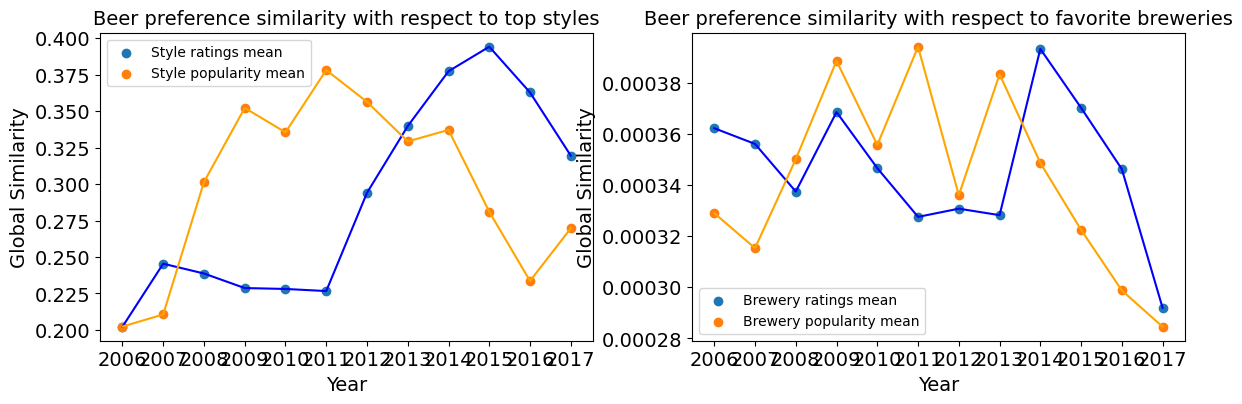

In [204]:
#Get the preference similarities between each pair of locations for each of the 4 categories
style_similarity_ratings = compute_similarity_countries(style_ratings_by_year_top3, ll_dict, jaccard_flag = True )
style_similarity_popularity = compute_similarity_countries(style_popularities_by_year_top3, ll_dict,  jaccard_flag = True)
brewery_similarity_popularity = compute_similarity_countries(bc_popularities_by_year, ll_dict, jaccard_flag = False)
brewery_similarity_ratings =compute_similarity_countries(bc_ratings_by_year, ll_dict, jaccard_flag = False)

column_names = ['location 1', 'location 2'] + [str(x) for x in range(2006, 2018)] # Giving consistent labels for each dataframe
similarity_columns = column_names[2:]

#Giving each dataframe the above-defined labels
style_similarity_ratings.columns = column_names
style_similarity_popularity.columns = column_names
brewery_similarity_popularity.columns = column_names
brewery_similarity_ratings.columns = column_names

#We plot the mean (global) similarity for each year, for each metric
style_ratings_mean = style_similarity_ratings[similarity_columns].mean().tolist()
style_popularity_mean = style_similarity_popularity[similarity_columns].mean().tolist()
brewery_popularity_mean = brewery_similarity_popularity[similarity_columns].mean().tolist()
brewery_ratings_mean = brewery_similarity_ratings[similarity_columns].mean().tolist()

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

axs[0].scatter(similarity_columns, style_ratings_mean, label='Style ratings mean')
axs[0].plot(similarity_columns, style_ratings_mean, linestyle='-', marker='', color='blue')
axs[0].scatter(similarity_columns, style_popularity_mean, label='Style popularity mean')
axs[0].plot(similarity_columns, style_popularity_mean, linestyle='-', marker='', color='orange')

# Customize the plots
axs[0].set_title('Beer preference similarity with respect to top styles', fontsize=14)
axs[0].set_xlabel('Year', fontsize=14)
axs[0].set_ylabel('Global Similarity', fontsize=14)
axs[0].legend()

axs[1].scatter(similarity_columns, brewery_ratings_mean, label='Brewery ratings mean')
axs[1].plot(similarity_columns, brewery_ratings_mean, linestyle='-', marker='', color='blue')
axs[1].scatter(similarity_columns, brewery_popularity_mean, label='Brewery popularity mean')
axs[1].plot(similarity_columns, brewery_popularity_mean, linestyle='-', marker='', color='orange')
axs[1].set_title('Beer preference similarity with respect to favorite breweries', fontsize=14)
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('Global Similarity', fontsize=14)
axs[1].legend()

plt.show()

In [85]:
style_ratings_mean

[0.20217303822937363,
 0.24539235412474883,
 0.2386720321931586,
 0.22869215291750333,
 0.22807511737089128,
 0.226633132126088,
 0.29400402414487253,
 0.33979879275654484,
 0.3773843058350141,
 0.39420523138833413,
 0.36281690140845557,
 0.3194902749832383]

In [239]:
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots


fig = go.Figure()

fig.add_trace(go.Scatter(x=similarity_columns, y=style_ratings_mean, name='Style ratings mean', line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=style_popularity_mean, name='Style popularity mean', line=dict(color='firebrick', width=4)))

fig.update_layout(title='Beer preference similarity with respect to top styles',
                  xaxis_title='Years',
                  yaxis_title='Global similarity',
                  title_x=0.5,
                  legend=dict(
                      yanchor="top",
                      y=0.99,
                      xanchor="left",
                      x=0.01
                  ))

fig.write_html('similarity_style_global.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

fig.show()


In [240]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_ratings_mean,name = 'Brewery ratings mean',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_popularity_mean,name = 'Brewery popularity mean',    line=dict(color='firebrick', width=4)))

fig.update_layout(title='Beer preference similarity with respect to favorite breweries',
                   xaxis_title='Years',
                   yaxis_title='Global similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="left",
                    x=0.01
))
fig.show()
fig.write_html('similarity_brewery_global.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [51]:
style_similarity_ratings.to_csv('dataset/PlotData/style_similarity_ratings.csv', index=False)
style_similarity_popularity.to_csv('dataset/PlotData/style_similarity_popularity.csv', index=False)
brewery_similarity_popularity.to_csv('dataset/PlotData/brewery_similarity_popularity.csv', index=False)
brewery_similarity_ratings.to_csv('dataset/PlotData/brewery_similarity_ratings.csv', index=False)

## *Investigating the role of geographical distance between locations in the similarities of their beer preferences*

In [246]:
#Finding the latitude and longitude of each location
location_list = users['location'].unique().tolist()
latitudes_longitudes = get_lat_long(location_list)

#We investigated the returned latitudes and longtitudes and found two of them (Germany and Sweden) are not correct. Therefore, we manually corrected them.
latitudes_longitudes['Germany'] = (52.517037, 13.388860)
latitudes_longitudes['Sweden'] = (59.329323, 18.068581)
location_distances_dict, location_distances_df = get_location_df(latitudes_longitudes)
location_distances_df

,Poland,Spain,Germany,Belgium,"United States, Connecticut","United States, Virginia","United States, Washington",Scotland,Denmark,Sweden,...,"United States, Hawaii","United States, Arkansas","United States, Kentucky","United States, Wyoming","United States, Alaska","United States, West Virginia","United States, North Dakota","United States, Vermont","United States, Rhode Island","United States, Montana"
Poland,0.000000,2332.787621,392.689746,1019.589163,6613.969522,7319.718518,7088.226412,1580.637627,693.338093,794.777292,...,12031.742215,8276.342961,7667.028506,8265.040069,7031.033661,7344.825413,7551.433482,6373.101297,6535.084658,7944.769552
Spain,2332.787621,0.000000,2025.543046,1461.145792,5608.065761,6265.917614,6064.937138,1942.114313,2136.298071,2748.943427,...,12804.256247,7460.486978,6764.492292,8024.661846,8095.769209,6382.889559,7290.895017,5477.343851,5514.096505,7868.668596
Germany,392.689746,2025.543046,0.000000,639.180588,6252.550733,6958.384695,6728.012976,1221.267157,403.826466,812.456840,...,11942.867607,7939.816272,7319.437793,7991.263966,6951.621279,6990.636061,7269.465519,6018.529943,6172.161518,7689.405018
Belgium,1019.589163,1461.145792,639.180588,0.000000,5785.529323,6488.498227,6262.361076,895.244555,675.566205,1288.194624,...,11984.262032,7531.743849,6885.998357,7724.292042,7050.608194,6540.877458,6990.273001,5572.578048,5701.024946,7462.528206
"United States, Connecticut",6613.969522,5608.065761,6252.550733,5785.529323,0.000000,705.865313,476.841688,5034.295658,5926.794605,6189.586790,...,7995.455651,1858.676981,1157.333287,2851.698831,5323.578080,775.786341,2289.799738,328.177686,95.825862,2973.036206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"United States, West Virginia",7344.825413,6382.889559,6990.636061,6540.877458,775.786341,255.531380,334.236304,5769.689598,6653.999055,6884.457805,...,7364.234808,1096.152010,391.809785,2303.612225,5227.479056,0.000000,1891.197325,972.109217,868.995409,2531.858029
"United States, North Dakota",7551.433482,7290.895017,7269.465519,6990.273001,2289.799738,2146.289427,2128.889995,6110.508322,6878.532586,6906.796827,...,5808.601947,1533.875663,1679.690024,739.341616,3463.039914,1891.197325,0.000000,2181.397620,2367.553136,685.653656
"United States, Vermont",6373.101297,5477.343851,6018.529943,5572.578048,328.177686,971.198066,737.094594,4797.584798,5682.644417,5922.809538,...,7956.999573,1991.345585,1316.416864,2800.861316,5067.584122,972.109217,2181.397620,0.000000,319.874873,2866.481173
"United States, Rhode Island",6535.084658,5514.096505,6172.161518,5701.024946,95.825862,787.647086,563.010666,4954.905661,5848.909635,6118.153809,...,8085.186792,1953.994740,1252.114682,2938.565889,5363.849009,868.995409,2367.553136,319.874873,0.000000,3051.867234


In [247]:
#For each location, retrieve the closest 15 locations and the farthest 15 locations from it and store them in a dictionary
fifteen_closest_locations, fifteen_farthest_locations = k_closest_and_farthest_locations(15, all_differences_dict = location_distances_dict)
fifteen_closest_locations

{'Poland': [('Germany', 392.68974618686343),
  ('Denmark', 693.3380930115135),
  ('Sweden', 794.7772917578416),
  ('Croatia', 803.2203644545177),
  ('Netherlands', 921.0763695991573),
  ('Luxembourg', 957.8451741026362),
  ('Belgium', 1019.589162881358),
  ('Italy', 1169.9280136153068),
  ('Finland', 1291.6153935958673),
  ('England', 1385.109652985167),
  ('France', 1393.8452514085413),
  ('Norway', 1444.0260410715848),
  ('Scotland', 1580.637626749268),
  ('Northern Ireland', 1745.1069722986633),
  ('Ireland', 1830.094858611715)],
 'Spain': [('France', 976.2843741584757),
  ('Luxembourg', 1434.8400788948948),
  ('Belgium', 1461.1457915869755),
  ('England', 1493.178576830061),
  ('Italy', 1515.9490053048003),
  ('Ireland', 1524.0099528633211),
  ('Netherlands', 1646.753032682805),
  ('Northern Ireland', 1703.90223468816),
  ('Croatia', 1810.8485894510948),
  ('Scotland', 1942.1143128481633),
  ('Germany', 2025.5430459424726),
  ('Denmark', 2136.2980706847115),
  ('Poland', 2332.78762

In [248]:
#Get the similarity for each group, for each of our metrics
closest_style_ratings, farthest_style_ratings = get_group_similarities(ratings, style_ratings_by_year_top3, k_closest_locs= fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag= True)
closest_style_popularity, farthest_style_popularity = get_group_similarities(ratings, style_popularities_by_year_top3, k_closest_locs= fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag= True)
closest_bc_ratings, farthest_bc_ratings = get_group_similarities(ratings, bc_ratings_by_year, k_closest_locs= fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag= False)
closest_bc_pop, farthest_bc_pop = get_group_similarities(ratings, bc_popularities_by_year, k_closest_locs=fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag=False)

In [181]:
closest_style_ratings.to_csv('dataset/PlotData/closest_style_ratings_distance.csv', index=False)
closest_style_popularity.to_csv('dataset/PlotData/closest_style_popularity_distance.csv', index=False)
closest_bc_ratings.to_csv('dataset/PlotData/closest_bc_ratings_distance.csv', index=False)
closest_bc_pop.to_csv('dataset/PlotData/closest_bc_pop_distance.csv', index=False)

farthest_style_ratings.to_csv('dataset/PlotData/farthest_style_ratings_distance.csv', index=False)
farthest_style_popularity.to_csv('dataset/PlotData/farthest_style_popularity_distance.csv', index=False)
farthest_bc_ratings.to_csv('dataset/PlotData/farthest_bc_ratings_distance.csv', index=False)
farthest_bc_pop.to_csv('dataset/PlotData/farthest_bc_pop_distance.csv', index=False)

### *Style preference similarities based on distance*

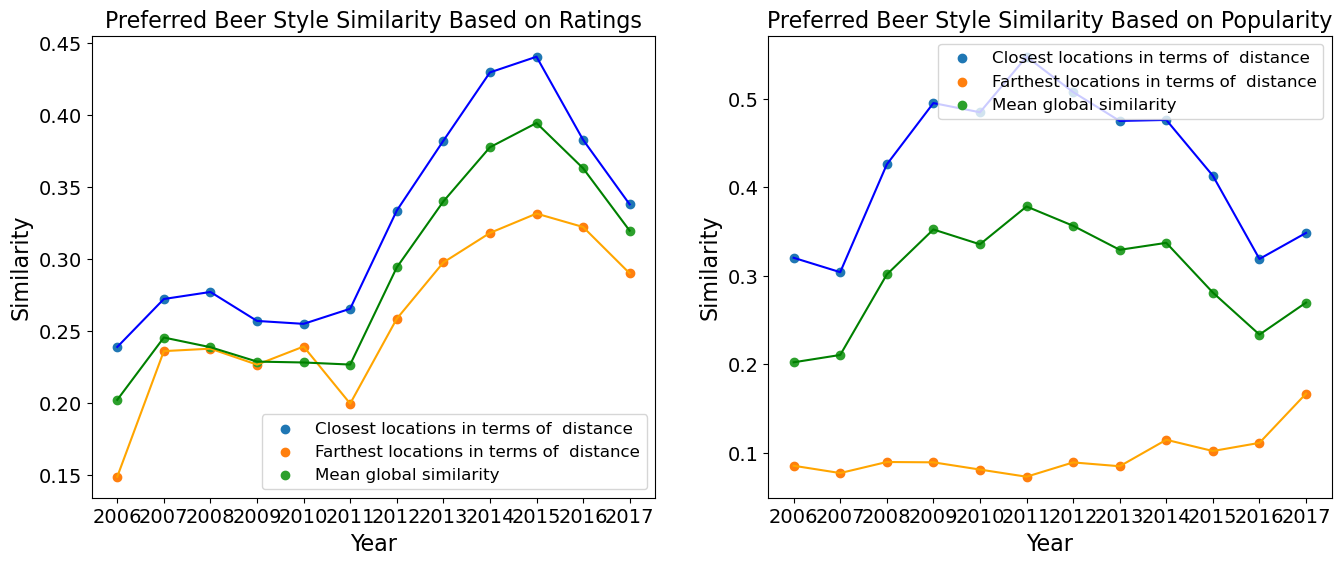

In [249]:
rename_columns = [str(x) for x in range(2006, 2018)]
closest_style_ratings.columns = farthest_style_ratings.columns = closest_style_popularity.columns = farthest_style_popularity.columns = closest_bc_ratings.columns = farthest_bc_ratings.columns = closest_bc_pop.columns = farthest_bc_pop.columns = rename_columns

plot_graphs(rename_columns, closest_style_ratings, farthest_style_ratings, style_similarity_ratings, closest_style_popularity, farthest_style_popularity, style_similarity_popularity, brewery_or_style = 'Preferred Beer Style', wealth_flag='distance')

In [250]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_ratings.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_ratings.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Beer Style Similarity Based on Ratings',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="left",
                    x=0.01
))
fig.show()
fig.write_html('style_similarity_ratings_grouped_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [251]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_popularity.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_popularity.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Beer Style Similarity Based on Popularity',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=1.1,
                    xanchor="right",
                    x=1
))
fig.show()
fig.write_html('style_similarity_popularity_grouped_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [252]:
#Group the two graphs

fig = make_subplots(rows=1, cols=2, subplot_titles=("Preferred Beer Style Similarity Based on Ratings", "Preferred Beer Style Similarity Based on Popularity"))

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_ratings.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_ratings.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)), row=1, col=1)

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_popularity.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_popularity.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4), showlegend=False), row=1, col=2)
fig.show()
fig.write_html('style_similarity_grouped_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

The results conform with the intuition as the global similarity curve is almost always between the closest and farthest similarity curves. Furthermore, we see that the rating based similarities have an increasing trend versus time whereas the popularity (consumption rate) similarities display both increasing and decreasing behavior and are roughly at the same level at the beginning and end of our time range.

Using the t_test_dataframe() function, we perform a t-test to see if the beer style preference difference between the mean similarity of the closest locations and the mean similarity of the farthest locations is statistically significant.

In [186]:
t_test_distance_style =t_test_dataframe(rename_columns, closest_style_ratings, farthest_style_ratings, style_similarity_ratings, closest_style_popularity, farthest_style_popularity, style_similarity_popularity)

In [187]:
t_test_distance_style.to_csv('dataset/PlotData/t_test_distance_style.csv', index=False)

**As we can see, the p value is lower than 0.05 in all years based on differences in both rating and consumption categories, expect for p-value from the year 2010 based on rating. So we can say in general that the beer style preference similarity significantly differs depending on whether it is calculated among geographically close or far locations. Furthermore, p values based on popularity is much smaller than the p-values based on rating. Therefore, geographic distance seems to play a bigger role on popularity (consumption rate) differences than rating differences.**

### *Brewery location preference similarities based on distance*

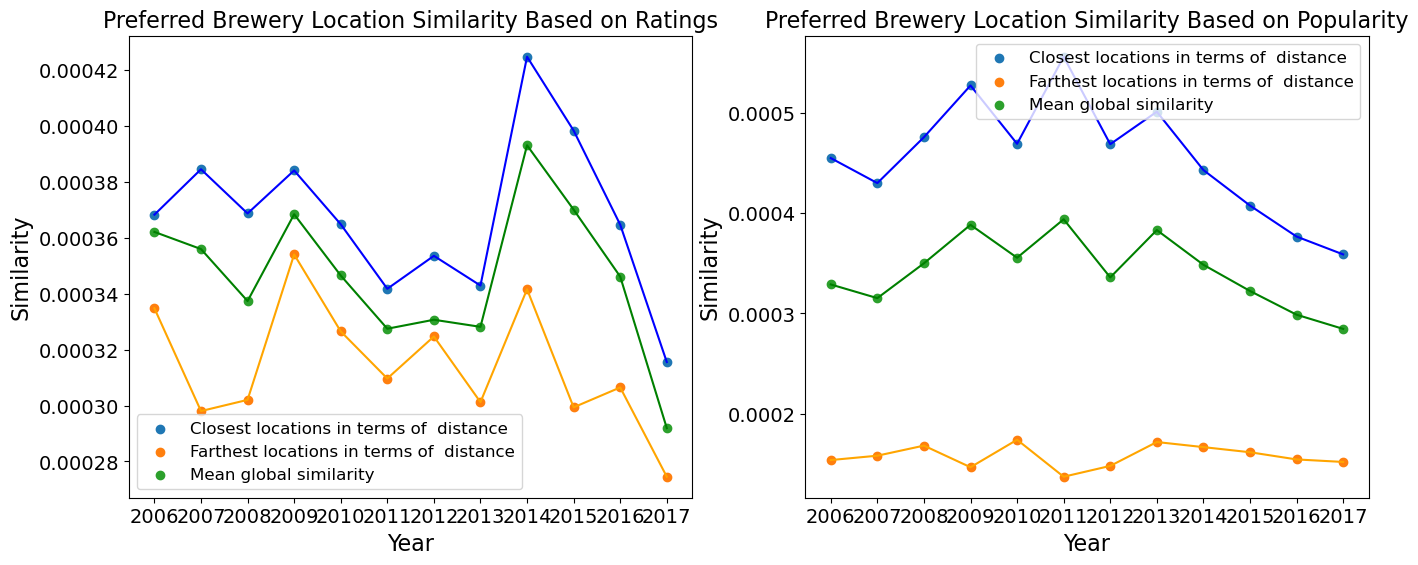

In [188]:
plot_graphs(rename_columns, closest_bc_ratings, farthest_bc_ratings, brewery_similarity_ratings, closest_bc_pop, farthest_bc_pop, brewery_similarity_popularity, brewery_or_style = 'Preferred Brewery Location', wealth_flag='distance')

In [253]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Preferred Brewery Location Similarity <br> Based on Ratings", "Preferred Brewery Location Similarity <br> Based on Popularity"))

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_ratings.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_ratings.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)), row=1, col=1)

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_pop.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_pop.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4), showlegend=False), row=1, col=2)
fig.show()
fig.write_html('brewery_similarity_grouped_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [254]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_ratings.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_ratings.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Brewery Location Similarity Based on Ratings',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=1.1,
                    xanchor="right",
                    x=1
))
fig.show()
fig.write_html('brewery_similarity_ratings_grouped_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [255]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_pop.mean(),name = 'Closest locations in terms of distance',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_pop.mean(),name = 'Farthest locations in terms of distance',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Brewery Location Similarity Based on Popularity',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=1.1,
                    xanchor="right",
                    x=1
))
fig.show()
fig.write_html('brewery_similarity_popularity_grouped_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

The results again conform with the intuition as the global similarity curve is almost always between the closest and farthest similarity curves. This time, we see that the rating based similarities have a decreasing trend (especially in the later years) versus time whereas the popularity (consumption rate) similarities display both increasing and decreasing behavior and are roughly at the same level at the beginning and end of our time range.

Using the t_test_dataframe() function, we perform a t-test to see if the brewery location preference difference between the mean similarity of the closest locations and the mean similarity of the farthest locations is statistically significant.

In [192]:
t_test_distance_bc = t_test_dataframe(rename_columns, closest_bc_ratings, farthest_bc_ratings, brewery_similarity_ratings, closest_bc_pop, farthest_bc_pop, brewery_similarity_popularity)

In [193]:
t_test_distance_bc.to_csv('dataset/PlotData/t_test_distance_bc.csv', index=False)

**As we can see, the p value is lower than 0.05 in all years based on differences in both rating and consumption categories, expect for p-value from the year 2006 based on rating. So we can say in general that the brewery location preference similarity significantly differs depending on whether it is calculated among geographically close or far locations. Furthermore, p-values based on popularity is much smaller than the p-values based on rating. Therefore, geographic distance seems to play a bigger role on popularity (consumption rate) differences than rating differences.**

## *Investigating the role of wealth (GDP per capita) of locations in the similarities of their beer preferences*

We know look at GDP per capita as a second potential factor that might affect the similarity of beer preferences between locations. We use the GDP per capita data from the World Bank. We use the data from 2008 as it was the only year for which we could find reliable data and it falls in our time range. First, we calculate the absolute difference of GDP per capita between each pair of locations and store them in a dictionary.

In [256]:
closest_and_farthest_distance = pd.read_csv('dataset/AdditionalData/Wealth_and_Lang.csv')

wealth_dict = {}
for index, row in closest_and_farthest_distance.iterrows():
    wealth_dict[row['Location']] = row['Money in 2008']

wealth_differences_dict = {}
for first_location in wealth_dict:
    wealth_differences_dict[first_location] = {}
    for second_location in wealth_dict:
        wealth_differences_dict[first_location][second_location] = abs(wealth_dict[first_location] - wealth_dict[second_location])

pd.DataFrame(wealth_differences_dict)

,"United States, California","United States, Pennsylvania","United States, New York","United States, Illinois","United States, Massachusetts","United States, Texas",Canada,"United States, Ohio","United States, Florida","United States, Michigan",...,"United States, Idaho","United States, Montana","United States, Alaska","United States, Hawaii","United States, North Dakota",Croatia,"United States, Wyoming",Northern Ireland,Iceland,Luxembourg
"United States, California",0.000,7211.000,2759.000,1516.140,6665.000,4103.000,9208.000,9761.968,12564.636,14636.102,...,17031.232,14799.325,18210.120,2280.160,16438.100,40060.300,20390.537,24689.130,1025.400,64504.100
"United States, Pennsylvania",7211.000,0.000,9970.000,5694.860,13876.000,3108.000,1997.000,2550.968,5353.636,7425.102,...,9820.232,7588.325,25421.120,4930.840,23649.100,32849.300,27601.537,17478.130,8236.400,71715.100
"United States, New York",2759.000,9970.000,0.000,4275.140,3906.000,6862.000,11967.000,12520.968,15323.636,17395.102,...,19790.232,17558.325,15451.120,5039.160,13679.100,42819.300,17631.537,27448.130,1733.600,61745.100
"United States, Illinois",1516.140,5694.860,4275.140,0.000,8181.140,2586.860,7691.860,8245.828,11048.496,13119.962,...,15515.092,13283.185,19726.260,764.020,17954.240,38544.160,21906.677,23172.990,2541.540,66020.240
"United States, Massachusetts",6665.000,13876.000,3906.000,8181.140,0.000,10768.000,15873.000,16426.968,19229.636,21301.102,...,23696.232,21464.325,11545.120,8945.160,9773.100,46725.300,13725.537,31354.130,5639.600,57839.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Croatia,40060.300,32849.300,42819.300,38544.160,46725.300,35957.300,30852.300,30298.332,27495.664,25424.198,...,23029.068,25260.975,58270.420,37780.140,56498.400,0.000,60450.837,15371.170,41085.700,104564.400
"United States, Wyoming",20390.537,27601.537,17631.537,21906.677,13725.537,24493.537,29598.537,30152.505,32955.173,35026.639,...,37421.769,35189.862,2180.417,22670.697,3952.437,60450.837,0.000,45079.667,19365.137,44113.563
Northern Ireland,24689.130,17478.130,27448.130,23172.990,31354.130,20586.130,15481.130,14927.162,12124.494,10053.028,...,7657.898,9889.805,42899.250,22408.970,41127.230,15371.170,45079.667,0.000,25714.530,89193.230
Iceland,1025.400,8236.400,1733.600,2541.540,5639.600,5128.400,10233.400,10787.368,13590.036,15661.502,...,18056.632,15824.725,17184.720,3305.560,15412.700,41085.700,19365.137,25714.530,0.000,63478.700


In [257]:
#For each location, retrieve the closest 15 locations and the farthest 15 locations from it (in terms of GDP per capita) and store them in a dictionary.
fifteen_closest_locations, fifteen_furthest_locations = k_closest_and_farthest_locations(15, wealth_differences_dict)

In [258]:
#Get the similarity for each group, for each of our metrics
closest_style_ratings, farthest_style_ratings = get_group_similarities(ratings, style_ratings_by_year_top3, k_closest_locs= fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag= True)
closest_style_popularity, farthest_style_popularity = get_group_similarities(ratings, style_popularities_by_year_top3, k_closest_locs= fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag= True)
closest_bc_ratings, farthest_bc_ratings = get_group_similarities(ratings, bc_ratings_by_year, k_closest_locs= fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag= False)
closest_bc_pop, farthest_bc_pop = get_group_similarities(ratings, bc_popularities_by_year, k_closest_locs=fifteen_closest_locations, k_farthest_locs=fifteen_farthest_locations, ll_dict=ll_dict, jaccard_flag=False)

In [208]:
closest_style_ratings.to_csv('dataset/PlotData/closest_style_ratings_wealth.csv', index=False)
closest_style_popularity.to_csv('dataset/PlotData/closest_style_popularity_wealth.csv', index=False)
closest_bc_ratings.to_csv('dataset/PlotData/closest_bc_ratings_wealth.csv', index=False)
closest_bc_pop.to_csv('dataset/PlotData/closest_bc_pop_wealth.csv', index=False)
farthest_style_ratings.to_csv('dataset/PlotData/farthest_style_ratings_wealth.csv', index=False)
farthest_style_popularity.to_csv('dataset/PlotData/farthest_style_popularity_wealth.csv', index=False)
farthest_bc_ratings.to_csv('dataset/PlotData/farthest_bc_ratings_wealth.csv', index=False)
farthest_bc_pop.to_csv('dataset/PlotData/farthest_bc_pop_wealth.csv', index=False)


### *Style preference similarities based on GDP per capita*

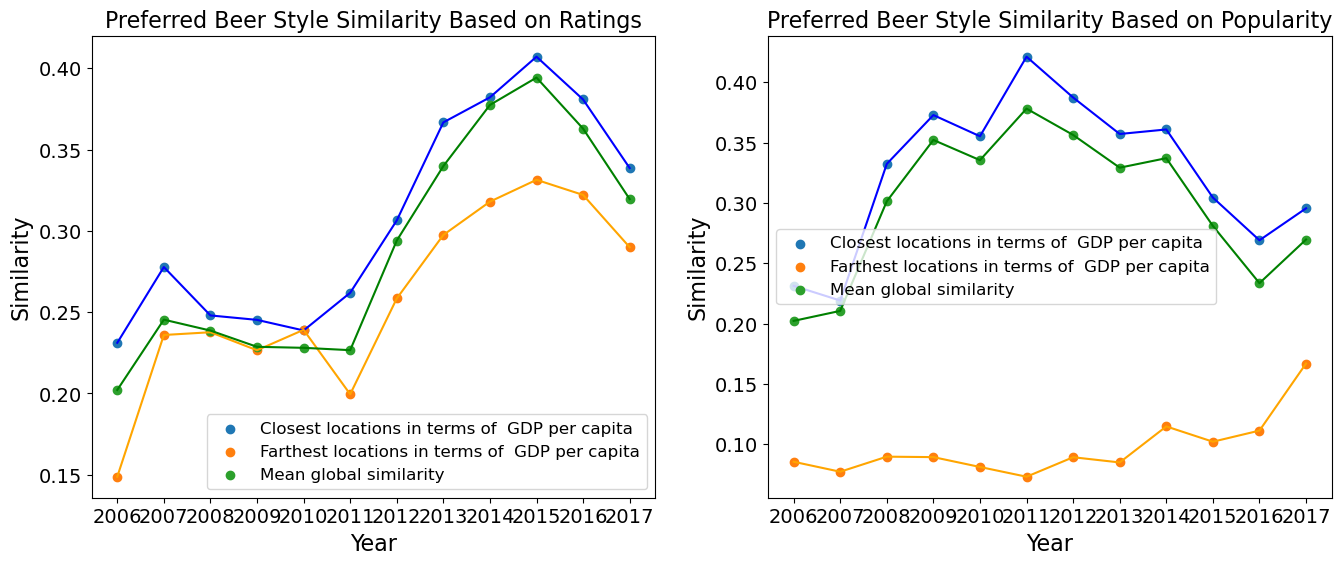

In [259]:
rename_columns = [str(x) for x in range(2006, 2018)]
closest_style_ratings.columns = farthest_style_ratings.columns = closest_style_popularity.columns = farthest_style_popularity.columns = closest_bc_ratings.columns = farthest_bc_ratings.columns = closest_bc_pop.columns = farthest_bc_pop.columns = rename_columns

plot_graphs(rename_columns, closest_style_ratings, farthest_style_ratings, style_similarity_ratings, closest_style_popularity, farthest_style_popularity, style_similarity_popularity, brewery_or_style = 'Preferred Beer Style', wealth_flag='GDP per capita')

In [260]:

fig = make_subplots(rows=1, cols=2, subplot_titles=("Preferred Beer Style Similarity <br> Based on Ratings", "Preferred Beer Style Similarity <br> Based on Popularity"))

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_ratings.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_ratings.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)), row=1, col=1)

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_popularity.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_popularity.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4), showlegend=False), row=1, col=2)
fig.show()
fig.write_html('style_similarity_grouped_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [261]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_ratings.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_ratings.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Beer Style Similarity Based on Ratings',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="left",
                    x=0.01
))
fig.show()
fig.write_html('style_similarity_ratings_grouped_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [262]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=similarity_columns, y=closest_style_popularity.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_style_popularity.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=style_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Beer Style Similarity Based on Popularity',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=1.1,
                    xanchor="right",
                    x=1
))
fig.show()
fig.write_html('style_similarity_popularity_grouped_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

The results again conform with the intuition as the global similarity curve is almost always between the closest and farthest similarity curves. Furthermore, we see that the rating based similarities have an increasing trend versus time whereas the popularity (consumption rate) similarities display both increasing and decreasing behavior and are roughly at the same level at the beginning and end of our time range.

Using the t_test_dataframe() function, we perform a t-test to see if the beer style preference difference between the mean similarity of the closest locations and the mean similarity of the farthest locations (in terms of GDP per capita) is statistically significant.

In [263]:
t_test_style_wealth = t_test_dataframe(rename_columns, closest_style_ratings, farthest_style_ratings, style_similarity_ratings, closest_style_popularity, farthest_style_popularity, style_similarity_popularity)

In [264]:
t_test_style_wealth.to_csv('dataset/PlotData/t_test_style_wealth.csv', index=False)

**As we can see, the p-value is lower than 0.05 in all years based on differences in both rating and consumption categories, expect for p-value from the years 2008 and 2010 based on rating. So we can say in general that the beer style preference similarity significantly differs depending on whether it is calculated among close or far locations in terms of GDP per capita. Furthermore, p-values based on popularity is much smaller than the p-values based on rating. Therefore, GDP per capita difference seems to play a bigger role on popularity (consumption rate) differences than rating differences.**

### *Brewery location preference similarities based on GDP per capita*

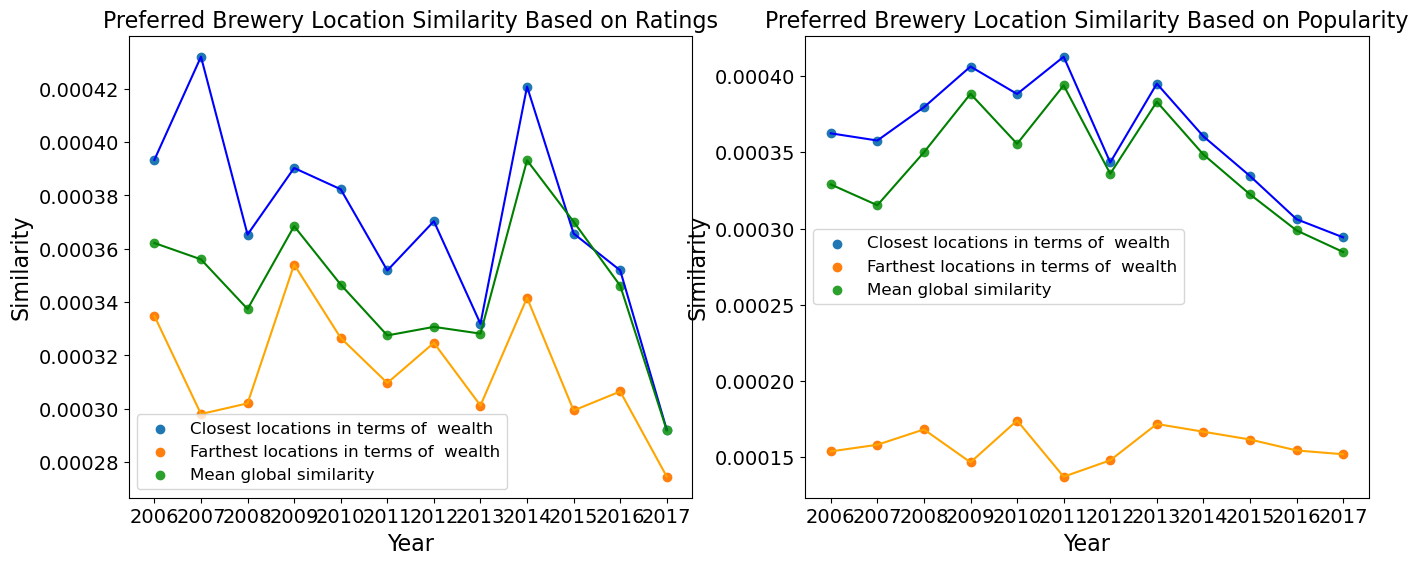

In [265]:
plot_graphs(rename_columns, closest_bc_ratings, farthest_bc_ratings, brewery_similarity_ratings, closest_bc_pop, farthest_bc_pop, brewery_similarity_popularity, brewery_or_style = 'Preferred Brewery Location', wealth_flag='wealth')

In [266]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Preferred Brewery Location Similarity  <br> Based on Ratings", "Preferred Brewery Location Similarity  <br> Based on Popularity"))

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_ratings.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_ratings.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)), row=1, col=1)

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_pop.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_pop.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4), showlegend=False), row=1, col=2)
fig.show()
fig.write_html('brewery_similarity_grouped_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [267]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_ratings.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_ratings.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_ratings.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Brewery Location Similarity Based on Ratings',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=1.1,
                    xanchor="right",
                    x=1
))
fig.show()
fig.write_html('brewery_similarity_ratings_grouped_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

In [268]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=similarity_columns, y=closest_bc_pop.mean(),name = 'Closest locations in terms of GDP per capita',   line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=farthest_bc_pop.mean(),name = 'Farthest locations in terms of GDP per capita',    line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=similarity_columns, y=brewery_similarity_popularity.iloc[:, 2:].mean(),name = 'Mean global similarity',    line=dict(color='green', width=4)))

fig.update_layout(title='Preferred Brewery Location Similarity Based on Popularity',
                   xaxis_title='Years',
                   yaxis_title='Similarity', 
                   title_x=0.5, 
                   legend=dict(
                    yanchor="top",
                    y=1.1,
                    xanchor="right",
                    x=1
))
fig.show()
fig.write_html('brewery_similarity_popularity_grouped_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

The results again conform with the intuition as the global similarity curve is almost always between the closest and farthest similarity curves. Furthermore, we see that the rating based similarities have a decreasing trend versus time (especially for the later years), whereas the popularity (consumption rate) similarities display both increasing and decreasing behavior and are roughly at the same level at the beginning and end of our time range.

It is interesting to realize that the difference in GDP per capita and the geographical distance result in very similar similarity curves since the last two line plots very closely resemble the first two line plots. This is probably because the GDP per capita and the geographical distance are highly correlated since the locations in the same continent (individual states of the U.S., North European countries such as Norway and Finland, etc.) have relatively close levels of wealth and are also geographically close to each other.

Using the t_test_dataframe() function, we perform a t-test to see if the brewery location preference difference between the mean similarity of the closest locations and the mean similarity of the farthest locations (in terms of GDP per capita) is statistically significant.

In [73]:
t_test_brewery_wealth = t_test_dataframe(rename_columns, closest_bc_ratings, farthest_bc_ratings, brewery_similarity_ratings, closest_bc_pop, farthest_bc_pop, brewery_similarity_popularity)

In [74]:
t_test_brewery_wealth.to_csv('dataset/PlotData/t_test_brewery_wealth.csv', index=False)

**As we can see, the p-value is lower than 0.05 in all years based on differences in both rating and consumption categories. So we can say that the brewery location preference similarity significantly differs depending on whether it is calculated among close or far locations in terms of GDP per capita. Furthermore, p-values based on popularity is much smaller than the p-values based on rating. Therefore, GDP per capita difference seems to play a bigger role on popularity (consumption rate) differences than rating differences.**

## *Beer Brotherhood*

Wouldn't it be interesting to see which locations are the closest in terms of beer preferences? Of course, we have to keep in mind that we have four beer preference similarity metrics. To have a sensible single similarity value, we will find four beer preference similarities between each pair of locations, standardize each of the four metrics and then add them up into a single value. Then, the resulting overall similarities between each pair of locations for each year will be aggregated over the years such that we end up with a single beer preference similarity value for each pair of locations.

In [37]:
style_similarity_ratings_standardized = style_similarity_ratings.copy()
style_similarity_pop_standardized = style_similarity_popularity.copy()
bc_sim_ratings_standardized =brewery_similarity_ratings.copy()
bc_sim_pop_standardized =  brewery_similarity_popularity.copy()
final_res = pd.DataFrame()
final_res['location 1'] = style_similarity_ratings['location 1']
final_res['location 2'] = style_similarity_ratings['location 2']

#Standardize each metric for each year by subtracting the mean and dividing by the standard deviation (finding a z-score)
for i in range(2006, 2018):
    string_year = str(i)
    style_similarity_ratings_standardized[string_year] = style_similarity_ratings_standardized[string_year].apply(lambda x:  (x - style_similarity_ratings_standardized[string_year].mean())/style_similarity_ratings_standardized[string_year].std() )
    style_similarity_pop_standardized[string_year] = style_similarity_pop_standardized[string_year].apply(lambda x:  (x - style_similarity_pop_standardized[string_year].mean())/style_similarity_pop_standardized[string_year].std() )
    bc_sim_ratings_standardized[string_year] = bc_sim_ratings_standardized[string_year].apply(lambda x:  (x - bc_sim_ratings_standardized[string_year].mean())/bc_sim_ratings_standardized[string_year].std() )
    bc_sim_pop_standardized[string_year] = bc_sim_pop_standardized[string_year].apply(lambda x:  (x - bc_sim_pop_standardized[string_year].mean())/bc_sim_pop_standardized[string_year].std() )
    final_res[string_year] = bc_sim_pop_standardized[string_year] + bc_sim_ratings_standardized[string_year] + style_similarity_pop_standardized[string_year]+style_similarity_ratings_standardized[string_year]

In [38]:
#Take mean of year similarities for each pair, and get the top 10 pairs: 
year_columns = [col for col in final_res.columns if col.startswith('2')]
mean_similarities = final_res[year_columns].mean(axis=1)
final_res['mean similarity'] = mean_similarities

#Get the top ten "beer brothers" considering the overall similarity
top_10_indices = final_res['mean similarity'].nlargest(10).index
top_10_df = final_res.loc[top_10_indices, ['location 1', 'location 2', 'mean similarity']]
top_10_df

,location 1,location 2,mean similarity
1840,"United States, Illinois","United States, Ohio",5.303777
2102,"United States, Massachusetts","United States, Virginia",5.211756
2089,"United States, Massachusetts","United States, New York",5.166107
2090,"United States, Massachusetts","United States, North Carolina",5.137181
2344,"United States, New York","United States, Virginia",5.125899
1875,"United States, Indiana","United States, Ohio",5.044221
1526,"United States, California","United States, Oregon",5.037348
1498,"United States, California","United States, Florida",4.961079
1739,"United States, Georgia","United States, Virginia",4.927171
1595,"United States, Connecticut","United States, Massachusetts",4.915007


In [75]:
top_10_df.to_csv('dataset/PlotData/top_10_beer_brothers.csv', index=False)

Unsurprisingly, all the most similar location pairs in terms of beer preferences are different states of the U.S. In order to have a more meaningful result, we need to again combine different states of the U.S. under the name 'United States' and then find the most similar location pairs. We make this update below.

In [39]:
final_res_filtered = final_res.copy()
final_res_filtered['location 1'] = final_res_filtered['location 1'].apply(lambda x: 'United States' if x.startswith('United States') else x)
final_res_filtered['location 2'] = final_res_filtered['location 2'].apply(lambda x: 'United States' if x.startswith('United States') else x)

#Remove line where location 1 and location 2 are the same
final_res_filtered = final_res_filtered[final_res_filtered['location 1'] != final_res_filtered['location 2']]

#Take the mean of the lines that have the same location 1 and 2
final_res_filtered = final_res_filtered.groupby(['location 1', 'location 2']).mean().reset_index()

We know have the preference similarities between each pair of locations for each year. We now aggregate the similarities over the years and find the most similar location pairs. We also find the least similar location pairs to see if there are any interesting results.

In [40]:
year_columns = [col for col in final_res_filtered.columns if col.startswith('2')]
mean_similarities = final_res_filtered[year_columns].mean(axis=1)
final_res_filtered['mean similarity'] = mean_similarities
top_3_indices_filtered = final_res_filtered['mean similarity'].nlargest(3).index
bottom_3_indices_filtered = final_res_filtered['mean similarity'].nsmallest(3).index
top_3_df_filtered = final_res_filtered.loc[top_3_indices_filtered, ['location 1', 'location 2', 'mean similarity']]
bottom_3_df_filtered = final_res_filtered.loc[bottom_3_indices_filtered, ['location 1', 'location 2', 'mean similarity']]

### **Top 3 most similar country pairs in terms of beer preference - a.k.a. Beer Brothers:**

In [41]:
top_3_df_filtered

,location 1,location 2,mean similarity
129,England,Scotland,3.388719
34,Belgium,Netherlands,2.423362
142,Finland,Norway,2.249135


In [76]:
top_3_df_filtered.to_csv('dataset/PlotData/top_3_beer_brothers_filtered.csv', index=False)

The results definitely make sense as we know these are culturally similar pair of countries.

### **Top 3 least similar country pairs in terms of beer preference - a.k.a. Beer Enemies:**

In [42]:
bottom_3_df_filtered

,location 1,location 2,mean similarity
12,Australia,Luxembourg,-3.064887
165,Germany,Luxembourg,-2.832610
215,Luxembourg,Sweden,-2.828275


In [77]:
bottom_3_df_filtered.to_csv('dataset/PlotData/bottom_3_beer_brothers_filtered.csv', index=False)

It looks like Iceland has the highest number of beer enemies to watch out for!

## *Investigating the correlation of GDP per capita difference or geographic distance between locations to their beer preference similarities*

We now have a single similarity value for each pair of locations. As the last step, want to see if there is a correlation between the similarity of beer preferences between two locations and their GDP per capita difference or geographic distance. Then, we can calculate the correlation coefficient between the similarity of beer preferences and GDP per capita difference or geographic distance. We use the correlation_coefficient() function defined in helpers.py file to calculate the correlation coefficient using pearsonr() function from scipy.stats library. Then, we plot the correlation coefficients versus year.

In [43]:
correlation_similarity_distance, _ = correlation_coefficient(final_res, ll_dict, distance=True)
correlation_similarity_wealth, _ = correlation_coefficient(final_res, wealth_dict, distance=False)

In [83]:

correlation_similarity_distance_df = pd.DataFrame()  # Define the variable correlation_similarity_distance_df
correlation_similarity_distance_df.to_csv('dataset/PlotData/correlation_similarity_distance.csv', index=True)

correlation_similarity_wealth_df = pd.DataFrame()  # Define the variable correlation_similarity_wealth_df
correlation_similarity_wealth_df.to_csv('dataset/PlotData/correlation_similarity_wealth.csv', index=True)


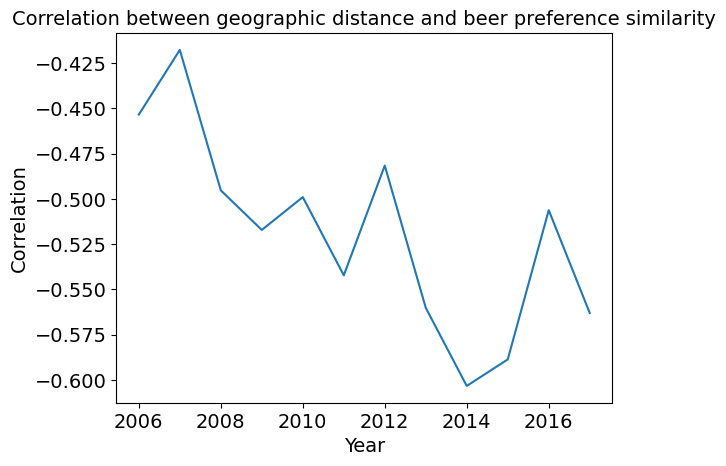

In [44]:
plot_correlation(correlation_similarity_distance, 'Correlation between geographic distance and beer preference similarity')

In [269]:
fig = px.line(x=list(correlation_similarity_distance.keys()), y=list(correlation_similarity_distance.values()))
#Add title
fig.update_layout(title='Correlation between geographic distance and beer preference similarity', xaxis_title='Years', yaxis_title='Correlation', title_x=0.5)
fig.show()

fig.write_html('correlation_similarity_distance.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

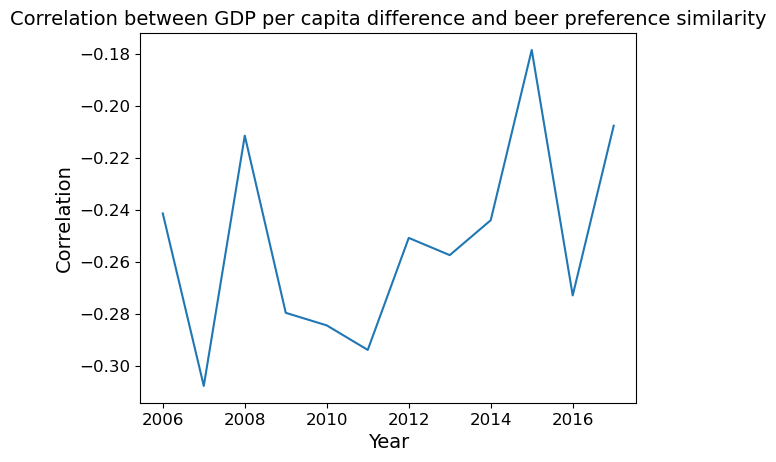

In [45]:
plot_correlation(correlation_similarity_wealth, 'Correlation between GDP per capita difference and beer preference similarity')

In [270]:
fig = px.line(x=list(correlation_similarity_wealth.keys()), y=list(correlation_similarity_wealth.values()))
#Add title
fig.update_layout(title='Correlation between GDP per capita difference and beer preference similarity', xaxis_title='Years', yaxis_title='Correlation', title_x=0.5)
fig.show()
fig.write_html('correlation_similarity_wealth.html', include_plotlyjs=False, include_mathjax=False, full_html=False)

The correlations are negative across all years, which means that the beer preference similarity decreases as the geographic distance or GDP per capita difference between the locations increases. Again, this conforms with the intuition.